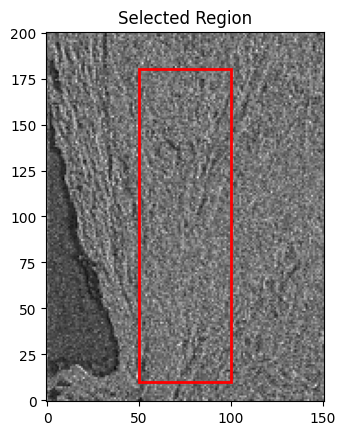

Gaussian 1: Amplitude = 0.03271925820895892, Center = 1640.0433458960285, Width = 19.94595250133522
Gaussian 2: Amplitude = 0.0643474399785311, Center = 1666.5689885762583, Width = 15.295965098817636


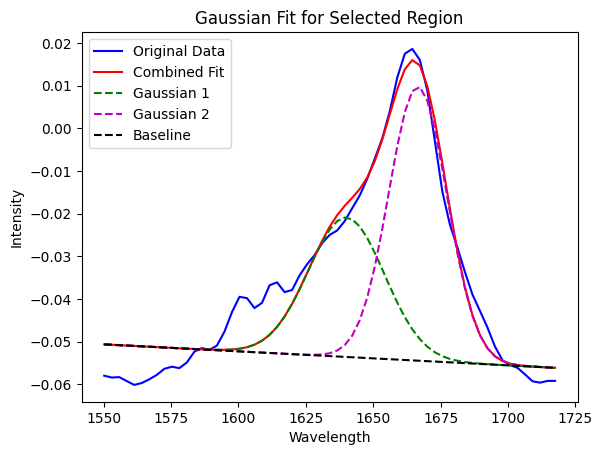

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import dual_annealing
from my_func.Read_ibw import read_ibw

# ガウスフィット関数（2つのガウス関数の混合）
def gaussoffset_mixture(x, w0, w1, w2_1, w3_1, w4_1, w2_2, w3_2, w4_2):
    gauss1 = w2_1 * np.exp(-((x - w3_1) / w4_1) ** 2)
    gauss2 = w2_2 * np.exp(-((x - w3_2) / w4_2) ** 2)
    return w0 + w1 * x + gauss1 + gauss2

# コスト関数（フィッティング用）
def cost_function(params, x, y):
    return np.sum((gaussoffset_mixture(x, *params) - y) ** 2)

# フィッティングを行う関数（パラメータの範囲を修正）
def perform_fit(x, y):
    bounds = [
        (-0.1, 0.1),    # w0 (ベースラインのオフセット)
        (-0.5, 0.5),    # w1 (ベースラインの線形項)
        (0.01, 0.1),    # w2_1 (ガウス1の振幅)
        (1640, 1655),   # w3_1 (ガウス1の中心)
        (5, 20),        # w4_1 (ガウス1の幅)
        (0.01, 0.1),    # w2_2 (ガウス2の振幅)
        (1650, 1680),   # w3_2 (ガウス2の中心)
        (5, 20)         # w4_2 (ガウス2の幅)
    ]
    result = dual_annealing(cost_function, bounds, args=(x, y))
    return result.x

# プロット関数（パラメータの出力追加）
def plot_fit(x, y, params):
    w0, w1, w2_1, w3_1, w4_1, w2_2, w3_2, w4_2 = params
    gauss1 = w2_1 * np.exp(-((x - w3_1) / w4_1) ** 2)
    gauss2 = w2_2 * np.exp(-((x - w3_2) / w4_2) ** 2)
    baseline = w0 + w1 * x
    combined_fit = baseline + gauss1 + gauss2

    print(f'Gaussian 1: Amplitude = {w2_1}, Center = {w3_1}, Width = {w4_1}')
    print(f'Gaussian 2: Amplitude = {w2_2}, Center = {w3_2}, Width = {w4_2}')

    plt.plot(x, y, 'b-', label='Original Data', markersize=4)
    plt.plot(x, combined_fit, 'r-', label='Combined Fit')
    plt.plot(x, baseline + gauss1, 'g--', label='Gaussian 1')
    plt.plot(x, baseline + gauss2, 'm--', label='Gaussian 2')
    plt.plot(x, baseline, 'k--', label='Baseline')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.legend()
    plt.title('Gaussian Fit for Selected Region')
    plt.show()

# 波長範囲1600~1720に対応するデータを抽出する関数
def extract_wavelength_range(data, wavelengths, start, end):
    mask = (wavelengths >= start) & (wavelengths <= end)
    selected_wavelengths = wavelengths[mask]
    selected_data = data[..., mask]  
    return selected_wavelengths, selected_data

# 領域内のスペクトル平均を計算する関数
def calculate_region_average(data, x_min, x_max, y_min, y_max):
    region_spectra = data[x_min:x_max+1, y_min:y_max+1, 0, :]
    avg_spectrum = np.mean(region_spectra, axis=(0, 1))
    return avg_spectrum

# 領域を赤い線で描画する関数
def plot_region_with_rectangle(image_data, x_min, x_max, y_min, y_max):
    plt.imshow(image_data.T, cmap='gray', origin='lower')
    plt.gca().add_patch(plt.Rectangle((y_min, x_min), y_max - y_min, x_max - x_min, 
                                      linewidth=2, edgecolor='r', facecolor='none'))
    plt.title('Selected Region')
    plt.show()

# データの読み込みと処理
def main():
    data = np.moveaxis(read_ibw('/Users/ootahiroki/Library/CloudStorage/Box-Box/KanoLab/Raman/data/1008H38_151_201_imchi3_dataOrig.ibw'), 0, -1)
    wavelengths = read_ibw('/Users/ootahiroki/Library/CloudStorage/Box-Box/KanoLab/Raman/data/1008H38_151_201_re_ramanshift2.ibw')

    selected_wavelengths, selected_data = extract_wavelength_range(data, wavelengths, 1550, 1720)

    y1, y2, x1, x2 = 10, 180, 50, 100

    # 領域 (例として座標を指定)
    avg_spectrum1 = calculate_region_average(selected_data, y1, y2, x1, x2)

    # 領域を画像に描画
    # データのz=0の成分（強度データ）を可視化するための2Dイメージを生成
    image_data = np.mean(data[:, :, 0, :], axis=2)
    plot_region_with_rectangle(image_data, y1, y2, x1, x2)  

    # ガウスフィッティングを行う
    params1 = perform_fit(selected_wavelengths, avg_spectrum1)

    # プロットを行う
    plot_fit(selected_wavelengths, avg_spectrum1, params1)

if __name__ == "__main__":
    main()
